In [1]:
import sys, os
ROOT = os.path.abspath("..")   # go up one directory from notebooks/
if ROOT not in sys.path:
    sys.path.append(ROOT)

print(ROOT)  


c:\Users\tdiks\Documents\PINN


In [2]:
from src2.networks import get_all_networks
from src2.config import CONFIG

from src2.sampling import (
    sample_domain_points,
    sample_top_surface,
    sample_interface,
    sample_far_field
)

from src2.losses import total_loss

from src2.pde_residuals import (
    residual_layer_coupled,
    residual_halfspace
)

from src2.boundary_conditions import (
    top_surface_bc,
    interface_layer_halfspace,
    halfspace_far_field_bc
)


# — Torch + Device

In [3]:
import torch
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


# Build-Models

In [4]:
model_layer, model_half = get_all_networks()

model_layer.to(DEVICE)
model_half.to(DEVICE)


PINN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): Tanh()
    (16): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Load Config & Geometry

In [5]:
geom = CONFIG["GEOMETRY"]

params_layer = CONFIG["LAYER"]
params_half  = CONFIG["HALFSPACE"]
dispersion = []   # <-- DEFINE DISPERSION HERE


# Define trainable phase velocity (c)

In [6]:
c = torch.nn.Parameter(
    torch.tensor(
        (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
        device=DEVICE
    )
)


# Optimizer

In [7]:
optimizer = optim.Adam(
    list(model_layer.parameters()) +
    list(model_half.parameters()) +
    [c],
    lr=1e-3
)


# Training Loop (Simple + Transparent)

In [8]:
dispersion = []   # <-- define once, BEFORE this block

# Training Loop (Dispersion)
k_values = torch.linspace(0, 3.0, 60)

for k in k_values:

    # Build-Models
    model_layer, model_half = get_all_networks()
    model_layer.to(DEVICE)
    model_half.to(DEVICE)

    # Define trainable phase velocity (c)
    c = torch.nn.Parameter(
        torch.tensor(
            (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
            device=DEVICE
        )
    )

    optimizer = optim.Adam(
        list(model_layer.parameters()) +
        list(model_half.parameters()) +
        [c],
        lr=1e-3
    )

    # -------- INNER TRAINING LOOP --------
    for epoch in range(1, 5):

        z_layer, z_half = sample_domain_points(3000, geom)
        z_top = sample_top_surface(1000, geom)
        z_int = sample_interface(1000)
        z_far = sample_far_field(1000, geom)

        optimizer.zero_grad()

        loss, logs = total_loss(
            model_layer,
            model_half,
            z_layer,
            z_half,
            z_top,
            z_int,
            z_far,
            params_layer,
            params_half,
            k.item()* geom["H"],   # <-- correct
            c,
            w_pde=1.0,
            w_bc=0.1,
            w_int=0.01,
            w_far=0.001
        )
    

        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(
                f"k={k.item():.2f} | "
                f"Epoch {epoch} | "
                f"Loss={loss.item():.3e} |"
                f"PDE={logs['pde']:.2e} | "
                f"BC={logs['bc_top']:.2e} | "
                f"INT={logs['interface']:.2e} | "
                f"FAR={logs['far']:.2e}"
            )

    
    dispersion.append([k.item(), c.item()])


In [9]:
torch.save({
    "model_layer": model_layer.state_dict(),
    "model_half": model_half.state_dict(),
    "c": c.detach().cpu()
}, "dispersion_pinn.pth")

print("Model saved.")


Model saved.


Choose time & y-location

In [10]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

H = geom["H"]   # layer thickness
L = geom["L"]   # half-space depth


Create a point in each layer

In [11]:
# z-grid for plotting / post-processing

z_layer = torch.linspace(-H, 0.0, 200).reshape(-1, 1).to(DEVICE)
z_half  = torch.linspace(0.0, L, 200).reshape(-1, 1).to(DEVICE)


Feed to model

In [12]:
with torch.no_grad():

    scale = 1e-2
# Layer (complex amplitude)   
    
V_layer = model_layer(z_layer)
V_R = scale * V_layer[:, 0:1]
V_I = scale * V_layer[:, 1:2]
# Half-space (real amplitude)
V_half = scale * model_half(z_half)



Plot Disperion curves


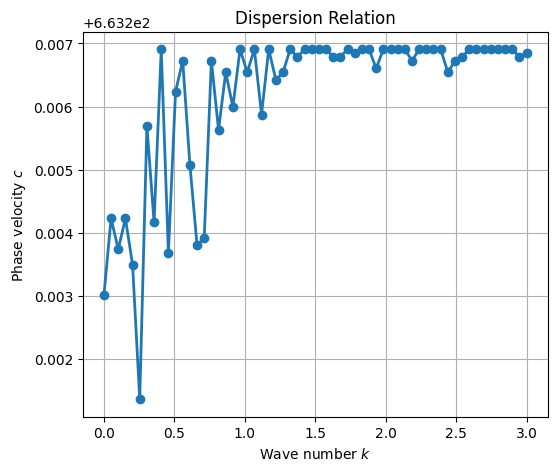

In [13]:
import matplotlib.pyplot as plt
import torch

# dispersion: shape (N, 2) → [k, c]
dispersion = torch.tensor(dispersion)
# dispersion: shape (N, 2) → [k, c]
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]


plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)

plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("Dispersion Relation")
plt.grid(True)

plt.show()
